In [2]:
!gdown '1XXCXLzrhHf_RAxJdRVArcB5QF8GN-CYu'

Downloading...
From: https://drive.google.com/uc?id=1XXCXLzrhHf_RAxJdRVArcB5QF8GN-CYu
To: /content/dataset.zip
100% 95.5M/95.5M [00:00<00:00, 115MB/s]


### 设置超参数

In [3]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [4]:
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [627.6153846153846, 872.6410256410256, ...],
  "image_path2" => [...]
}
```

In [5]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

json_dict = {}
for p in pathlib.Path('./dataset').glob('*'):
  plate = p.name  
  path = str(p)
  with open(f"{path}/{plate}.json") as file:
    os.mkdir(f"./resized/{plate}")

    resized_image_path = f"./resized/{plate}/{plate}.jpg"

    image = Image.open(f"{path}/{plate}.jpg")
    resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    resized_image.save(resized_image_path)

    labels = []
    for p in json.load(file)['shapes'][0]['points']:
      labels.append(p[0] / image.width)
      labels.append(p[1] / image.height)

    json_dict[resized_image_path] = labels  

### 构建数据集

In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

keys = list(json_dict.keys())
np.random.shuffle(keys)

train_keys, validation_keys = (keys[int(len(keys) * 0.1) :], keys[: int(len(keys) * 0.1)],)
train_labels = [json_dict[p] for p in train_keys]
validation_labels = [json_dict[p] for p in validation_keys]

def load_and_preprocess_image(plate, label):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0

  return img, label

train_dataset = (
  tf.data.Dataset.from_tensor_slices((train_keys, train_labels))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = (
  tf.data.Dataset.from_tensor_slices((validation_keys, validation_labels))
    .map(load_and_preprocess_image, tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
)

### 定义显示关键点方法

In [9]:
import numpy as np

def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(16, 12))
  [ax.axis("off") for ax in np.ravel(axes)]

  for ax_all, image, kp in zip(axes, images, keypoints):
    ax_all.imshow(image)
    for i in range(0, 4):
      ax_all.scatter([kp[i * 2] * IMG_SIZE], [kp[i * 2 + 1] * IMG_SIZE], c='red', marker="x", s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

### 检查一下数据

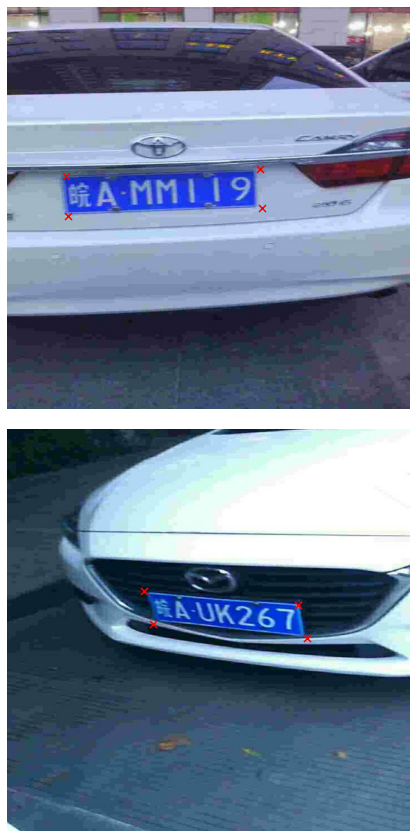

In [10]:
for image, points in train_dataset.take(1):
  sample_image, sample_points = image, points

visualize_keypoints(sample_image, sample_points)

### 构建模型

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(image_size):
  inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
  # Conv => Activation => Pool blocks.
  x = layers.Conv2D(33, kernel_size=(5, 5), activation='relu')(inputs)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x) 
  x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)   
  x = layers.MaxPool2D((2, 2))(x)                 
  # Linear layers.
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dense(units=NUM_KEYPOINTS)(x)
  model = tf.keras.Model(inputs, outputs=x)
  return model

### 生成模型

In [ ]:
model = build_model((IMG_SIZE, IMG_SIZE))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 621, 621, 33)      2508      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 310, 310, 33)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 308, 308, 33)      9834      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 154, 154, 33)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 152, 152, 33)      9834  

### 预览模型架构

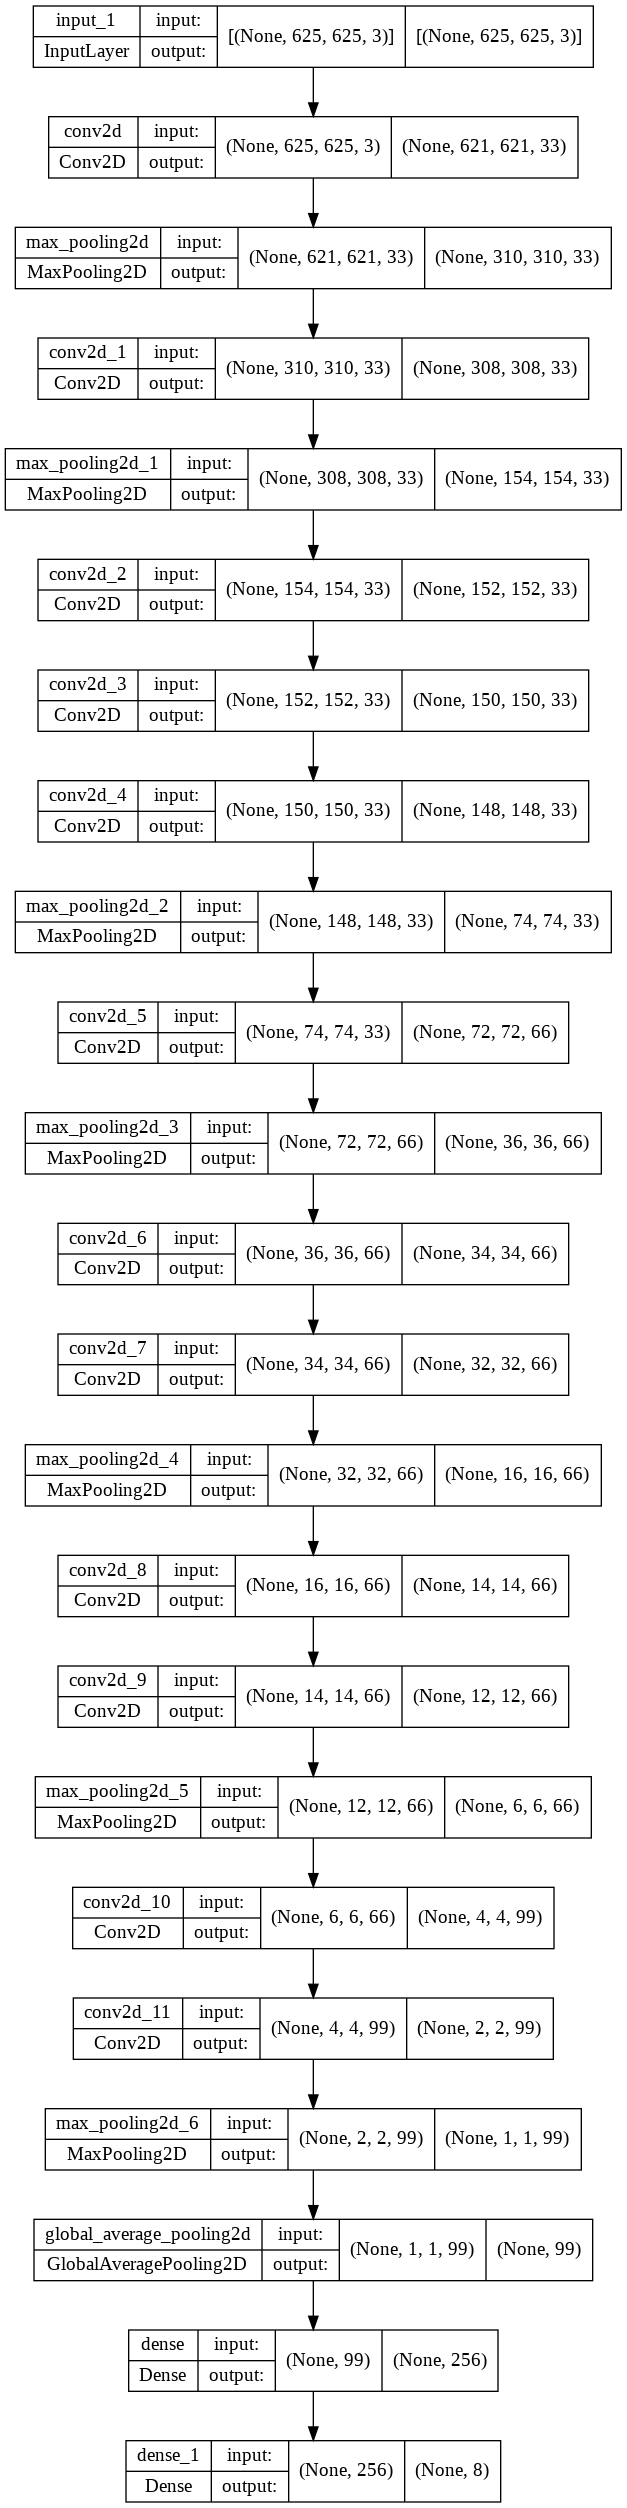

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
model = tf.keras.models.load_model('detect20220511.h5')

### 调整学习率

In [44]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-6))

### 训练

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/1000
1153/1153 [==============================] - 95s 82ms/step - loss: 4.1519e-05 - val_loss: 3.2979e-04


### 显示训练结果

实际


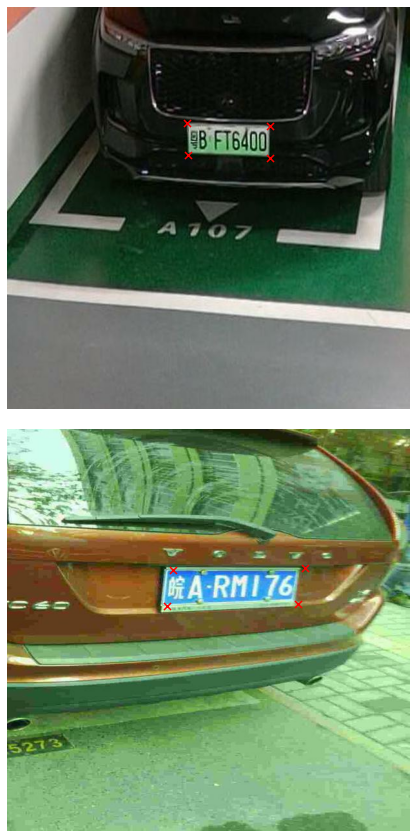

模型预测


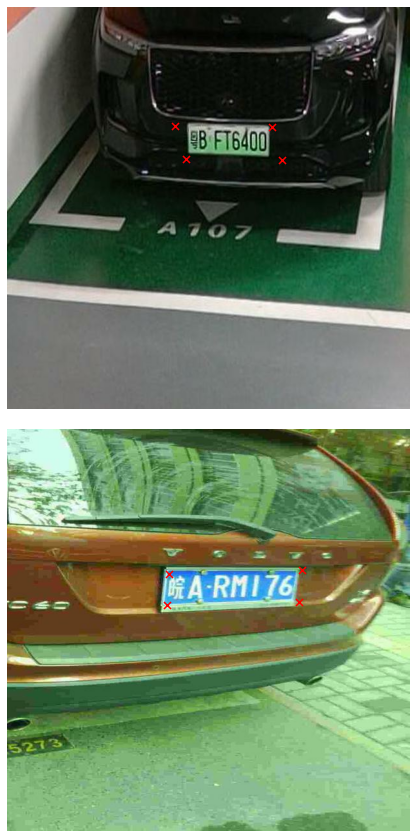

In [51]:
for image, points in validation_dataset.take(6):
  sample_image, sample_points = image, points

print('实际')
visualize_keypoints(sample_image, sample_points)

predictions = model.predict(sample_image)
print("模型预测")
visualize_keypoints(sample_image, predictions)

### 保存模型

In [52]:
model.save('detect20220511.h5')